# S pol flight experiments

Trying to compare S pol flights with other flights to get an idea of the impact of drone polarization

In [83]:
## First import general packages for running python analysis:
import os, h5py, datetime,pytz
import numpy as np
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import pickle, glob, yaml, string
from os import path

from scipy.interpolate import griddata
import scipy.optimize as opt
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
from scipy.optimize import least_squares
from scipy.stats import binned_statistic_2d

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator
from matplotlib.colorbar import Colorbar

## Then import the beamcals module packages and initialize 'gbosite' class:
from beamcals import corr
from beamcals import concat
from beamcals import drone
from beamcals import bicolog
import beamcals.plotting_utils as pu
import beamcals.fitting_utils as fu
import beamcals.geometry_utils as gu
import beamcals.time_utils as tu
from beamcals import beammap as bp
import beamcals.beam_autoprocessing as ba
from beamcals.sites import site
import beamcals.reduce_ccclass as rc

gbosite=site.site('../beamcals/beamcals/sites/GBO_config.npz')

# various gridding attempts
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging

freqs = 800.0*np.ones(1024) + (-400/1024.)*np.arange(1024)

fitdir='/hirax/GBO_Analysis_Outputs/main_beam_fits/'
ymldir = '/hirax/GBO_Analysis_Outputs/concat_config_files/'
pckldir = '/hirax/GBO_Analysis_Outputs/flight_pickles/'
ampdir = '/hirax/GBO_Analysis_Outputs/amplitude_corrections/'
beamdir = '/hirax/GBO_Analysis_Outputs/beam_pickles/'

## Laura's functions

In [2]:
def get_flightinfo(fly):
    for fi in range(0,len(documents["flight_info"]["flights"])):
        if fly == flights[fi]: f = fi
    
    if polarn[f]=='N':
        pols = N_pols
        cpols = E_pols
    else:
        pols = E_pols
        cpols = N_pols
    return polarn[f], pols, cpols, attns[f], f

def get_beam_diff(beam2, beam1,n):
    return beam2[:,:] - n*beam1[:,:]

def get_stat(new_d,whstat='stddev'): # default is stddev
    diff_flat = np.ndarray.flatten(new_d)
    if whstat=='stddev':
        stat = np.nanstd(diff_flat)
    elif whstat=='median':
        # compute median
        stat = np.abs(np.nanmedian(diff_flat))
    elif whstat=='sum':
        stat = np.nanmean(np.abs(diff_flat))
    elif whstat=='mednoabs':
        stat = np.nanmedian(diff_flat)
    return stat

def get_slice_old(beam,Z,val,ax='x'):
    # this gradually increases the tolerance until it finds something
    tol = abs(beam.x_centers_grid[0,1,0] - beam.x_centers_grid[0,0,0])/1.5
    N = len(beam.x_centers_grid[0,:,0])
    ok = True
    while(ok):
        if ax=='x':
            col = np.where((beam.x_centers_grid[0,:,0] < val+tol) & (beam.x_centers_grid[0,:,0] > val-tol))[0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
        if ax=='y':
            col = np.where((beam.y_centers_grid[:,0,0] < val+tol) & (beam.y_centers_grid[:,0,0] > val-tol))[0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
        tol+=3
        if tol > 30: ok = False
    return col

def get_slice_anyin(LX,LY,val,ax='x'):
    tol = abs(LX[0,1] - LX[0,0])/1.5
    if ax=='x':
        col = np.where((LX[0,:] < val+tol) & (LX[0,:] > val-tol))[0][0]
    if ax=='y':
        col = np.where((LY[:,0] < val+tol) & (LY[:,0] > val-tol))[0][0]
    return col

def get_slice(beam,Z,val, sliceOrientation='h'):
    # this gradually increases the tolerance until it finds something
    tol = abs(beam.x_centers_grid[1,0,0] - beam.x_centers_grid[0,0,0])/1.5
    N = len(beam.x_centers_grid[:,0,0]) #figure out the importance of this 
    ok = True
    while(ok):
        if sliceOrientation=='h': #keeping the y value constant and changing the x value 
            sliceIndex = np.where((beam.y_centers_grid[0,:,0] < (val + tol)) & (beam.y_centers_grid[0,:,0] > (val-tol)))[0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
                #still need to do this one 
        if sliceOrientation=='v':#keeping the x value constant and changing the y value 
            sliceIndex = np.where((beam.x_centers_grid[:,0,0] < (val+tol)) & (beam.x_centers_grid[:,0,0] > (val-tol)))[0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
        tol+=1
        if tol > 30: ok = False
    return sliceIndex[0]


def get_concatlist(flights):
    #for i, fly in enumerate(flights):
    pickle_directory='/hirax/GBO_Analysis_Outputs/flight_pickles/'
    concytest=[glob.glob(pickle_directory+'*'+fly+'*')[0] for fly in flights]
    return concytest

##  reads in flights

In [3]:
with open('/hirax/GBO_Analysis_Outputs/GBO_flights_forscripts.yaml', 'r') as fff:
    documents = yaml.safe_load(fff)
flights = documents["flight_info"]["flights"]
N_pols = documents["flag_info"]["N_pols"]
E_pols = documents["flag_info"]["E_pols"]
polarn = documents["flight_info"]["pols"]
attns = documents["flight_info"]["attns"]
masks = documents["flight_info"]["masks"]
good_freqs = documents["freq_info"]["good_freqs"]

print(len(flights))

pcklarr=np.sort(os.listdir(pckldir))
gfitarr=np.sort(os.listdir(fitdir))
amparr=np.sort(os.listdir(ampdir))
print(gfitarr,amparr)


# SLICE DEFAULTS # 
sliw = 10 # This defines slices for (some) plots
sz = 80 # use this to set the size of the Xargs and Yargs for beammapping, usually 80 or 50

# PLOTTING DEFAULT # 
cmap = matplotlib.cm.get_cmap('gnuplot2')
norm = matplotlib.colors.Normalize(vmin=-25, vmax=25)
sfig = False

Npolflights = ['619','625']
Spolflight = ['623']

12
['FLY533_20210826T182904Z_2dGauss_and_Airy_Params.npz'
 'FLY534_20210826T185621Z_2dGauss_and_Airy_Params.npz'
 'FLY535_20210826T192056Z_2dGauss_and_Airy_Params.npz'
 'FLY618_20211021T183430Z_2dGauss_and_Airy_Params.npz'
 'FLY619_20211021T185805Z_2dGauss_and_Airy_Params.npz'
 'FLY620_20211021T192212Z_2dGauss_and_Airy_Params.npz'
 'FLY623_20211021T203206Z_2dGauss_and_Airy_Params.npz'
 'FLY625_20211021T214028Z_2dGauss_and_Airy_Params.npz'
 'FLY646_20211022T183659Z_2dGauss_and_Airy_Params.npz'
 'FLY647_20211022T185749Z_2dGauss_and_Airy_Params.npz'
 'FLY648_20211022T191922Z_2dGauss_and_Airy_Params.npz'
 'FLY649_20211022T194308Z_2dGauss_and_Airy_Params.npz'] ['FLY533_Corrected_amplitudes.pkl' 'FLY534_Corrected_amplitudes.pkl'
 'FLY535_Corrected_amplitudes.pkl' 'FLY618_Corrected_amplitudes.pkl'
 'FLY619_Corrected_amplitudes.pkl' 'FLY620_Corrected_amplitudes.pkl'
 'FLY623_Corrected_amplitudes.pkl' 'FLY625_Corrected_amplitudes.pkl'
 'FLY646_Corrected_amplitudes.pkl' 'FLY647_Corrected_amplitu

## CARTESIAN VERSION ##

In [71]:
# In this cell I use a special (soon to be deprecated, Nov 2023) beam class
# this one happens to give real error bars as the stddev across all data in pixel

# Lets look at only the N-pol flights at the same attenuation, pick one frequency

#Npolflights = ['618','619','625']
Npolflights = ['618','619']

pflights=Npolflights
find=900#good_freqs[100]

concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for fly in pflights]


beam=ba.Beammap_forautoprocessing(concatlist=concytest,
                 normalization='Gauss_wcorr',operation='std',mask=True,
                                  coordsys='cartesian',d0args=[-1*sz,sz,2.5],
                 d1args=[-1*sz,sz,2.5],Fargs=[find,find+1,1])


start of big ass loop is: 2024-03-13 14:09:47.266612
618 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY618_20211021T183430Z_2dGauss_and_Airy_Params.npz
619 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY619_20211021T185805Z_2dGauss_and_Airy_Params.npz
end of bigass loop is: 2024-03-13 14:09:52.408651   
618 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY618_20211021T183430Z_2dGauss_and_Airy_Params.npz
619 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY619_20211021T185805Z_2dGauss_and_Airy_Params.npz


<ipython-input-72-07013d194194>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axs[0,i].pcolormesh(beam.d0_centers_grid[:,:,chind],beam.d1_centers_grid[:,:,chind],
<ipython-input-72-07013d194194>:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axs[1,i].pcolormesh(beam.d0_centers_grid[:,:,chind],beam.d1_centers_grid[:,:,chind],


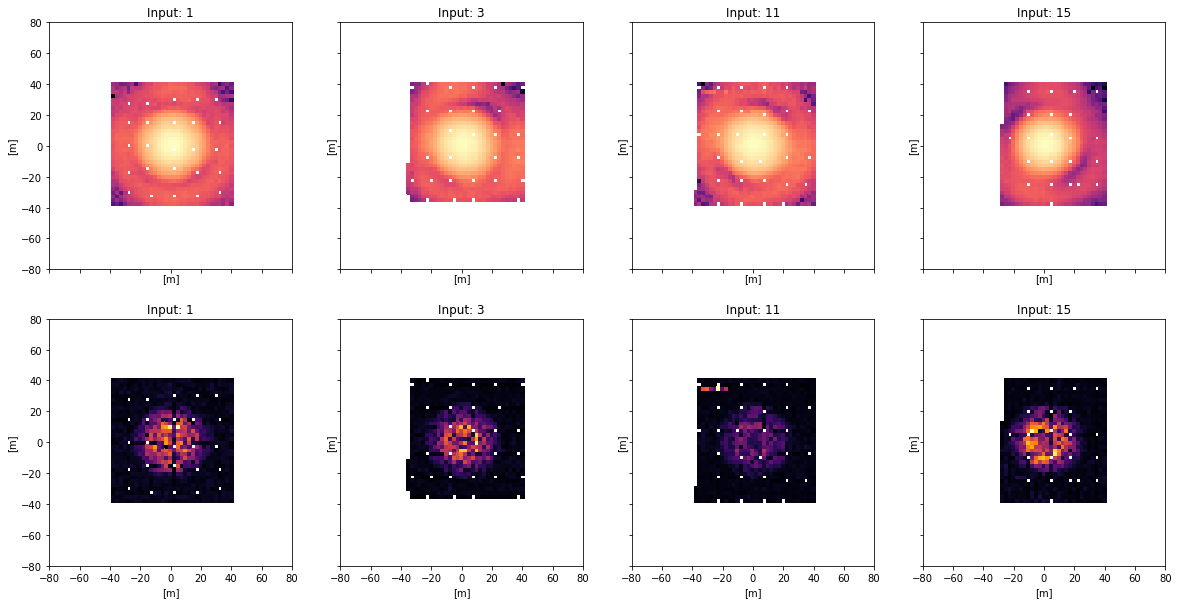

In [72]:
# Here let's just plot the beams and variances per input as a quick check

pols = N_pols

fig,axs = plt.subplots(2, 4, sharex=True,sharey=True,figsize=(20,10))
for i,chind in enumerate(pols):
    axs[0,i].pcolormesh(beam.d0_centers_grid[:,:,chind],beam.d1_centers_grid[:,:,chind],
               np.abs(beam.V_LC_operation[:,:,0,chind]),cmap=cm.magma,norm=LogNorm())#,edgecolors='k')
    axs[0,i].set_xlim(-1*sz,sz)
    axs[0,i].set_ylim(-1*sz,sz)
    axs[0,i].set_xlabel('[m]')
    axs[0,i].set_ylabel('[m]')
    axs[0,i].set_title('Input: '+str(chind))
    #axs[0,i].colorbar()

for i,chind in enumerate(pols):
    axs[1,i].pcolormesh(beam.d0_centers_grid[:,:,chind],beam.d1_centers_grid[:,:,chind],
               beam.V_LC_operation_err[:,:,0,chind],cmap=cm.inferno)#,edgecolors='k')
    axs[1,i].set_xlim(-1*sz,sz)
    axs[1,i].set_ylim(-1*sz,sz)
    axs[1,i].set_xlabel('[m]')
    axs[1,i].set_ylabel('[m]')
    axs[1,i].set_title('Input: '+str(chind))
    #plt.colorbar()
plt.show()

In [73]:
# Now let's read in flight 623 and apply the Gaussian normalization. 
# We'll also read in the correction based on matching sidelobes, and apply it

fly='623'

pol, pols, cpols, attn, fi = get_flightinfo(fly)
print(fly,pol,pols,cpols, attn)


fl623_grided=bp.Beammap(concatlist=pcklarr[[fi]],gfitlist=gfitarr[[fi]],
                 normalization='Gauss',operation='coadd',coordsys='cartesian',
                        d0args=[-1*sz,sz,2.5],
                 d1args=[-1*sz,sz,2.5],Fargs=[find,find+1,1],f_index_cc=find,vplot=False)


pklfile = ampdir+'FLY'+str(fly)+'_Corrected_amplitudes.pkl'
with open(pklfile, 'rb') as inp:
    amps = pickle.load(inp)
    
fl623 = fl623_grided.V_LC_mean[:,:,0,:,0]*amps[0,find,:] # must use this
fl623_err = fl623_grided.V_LC_std[:,:,0,:,0]*amps[0,find,:]

623 N [1, 3, 11, 15] [0, 2, 10, 14] 46
start of concat loop is: 2024-03-13 14:10:01.502824
end of concat loop is: 2024-03-13 14:10:05.937425          


In [74]:
# Do amplitude correction - this matches sidelobe region, should be a small correction 
print(amps[0,find,:])
fl623 = fl623_grided.V_LC_mean[:,:,0,:,0]*amps[0,find,:] # must use this
fl623_err = fl623_grided.V_LC_std[:,:,0,:,0]*amps[0,find,:]

#fl623 = fl623_grided.V_LC_mean[:,:,0,:,0]*1.0 # must use this
#fl623_err = fl623_grided.V_LC_std[:,:,0,:,0]*1.0

[0.    1.022 0.    0.975 0.    0.    0.    0.    0.    0.    0.    0.957
 0.    0.    0.    1.058]


In [75]:
# Create mask - mask anything that's NaN or 0.0 (cross pols are 0.0)
mx = np.ma.masked_invalid(fl623[:,:,:])
my = np.ma.masked_invalid(beam.V_LC_operation[:,:,0,:])

mx0 = np.ma.masked_equal(fl623[:,:,:],0.0)
my0 = np.ma.masked_equal(beam.V_LC_operation[:,:,0,:],0.0)
mxtot = np.logical_and(mx,my)
m0tot = np.logical_and(mx0,my0)
mtot = np.logical_and(m0tot,mxtot)

# Make masked data sets, and masked errors - put in nans wherever theres a mask
fl623d_mask = np.ma.masked_where(np.ma.getmask(mtot),fl623[:,:,:]).filled(np.nan)
cod_mask = np.ma.masked_where(np.ma.getmask(mtot),beam.V_LC_operation[:,:,0,:]).filled(np.nan)
fl623e_mask = np.ma.masked_where(np.ma.getmask(mtot),fl623_err[:,:,:]).filled(np.nan)
coe_mask = np.ma.masked_where(np.ma.getmask(mtot),beam.V_LC_operation_err[:,:,0,:]).filled(np.nan)

# Make masked difference array, shape (N, N, inputs)
diffarr = fl623d_mask - cod_mask

# Make masked std array, combine both variances, shape (N, N, inputs)
vararr = fl623e_mask**2 + coe_mask**2


<ipython-input-76-578ca907cfa0>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axs[0].pcolormesh(fl623_grided.d0_centers_grid[:,:,chind],fl623_grided.d1_centers_grid[:,:,chind],
<ipython-input-76-578ca907cfa0>:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axs[1].pcolormesh(beam.d0_centers_grid[:,:,chind],beam.d1_centers_grid[:,:,chind],
<ipython-input-76-578ca907cfa0>:23: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimension

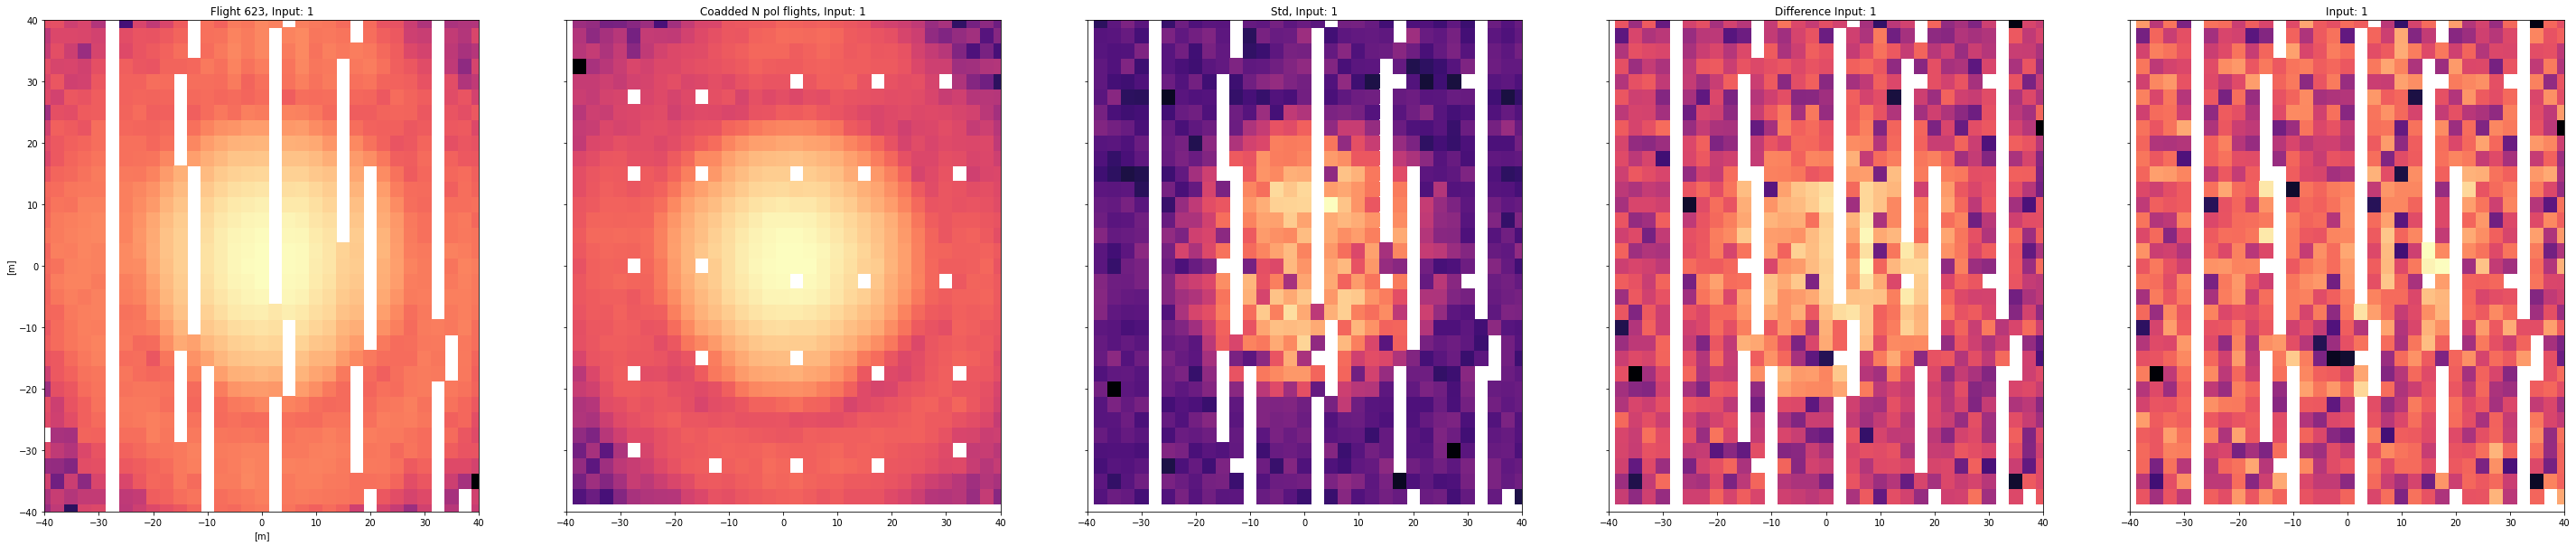

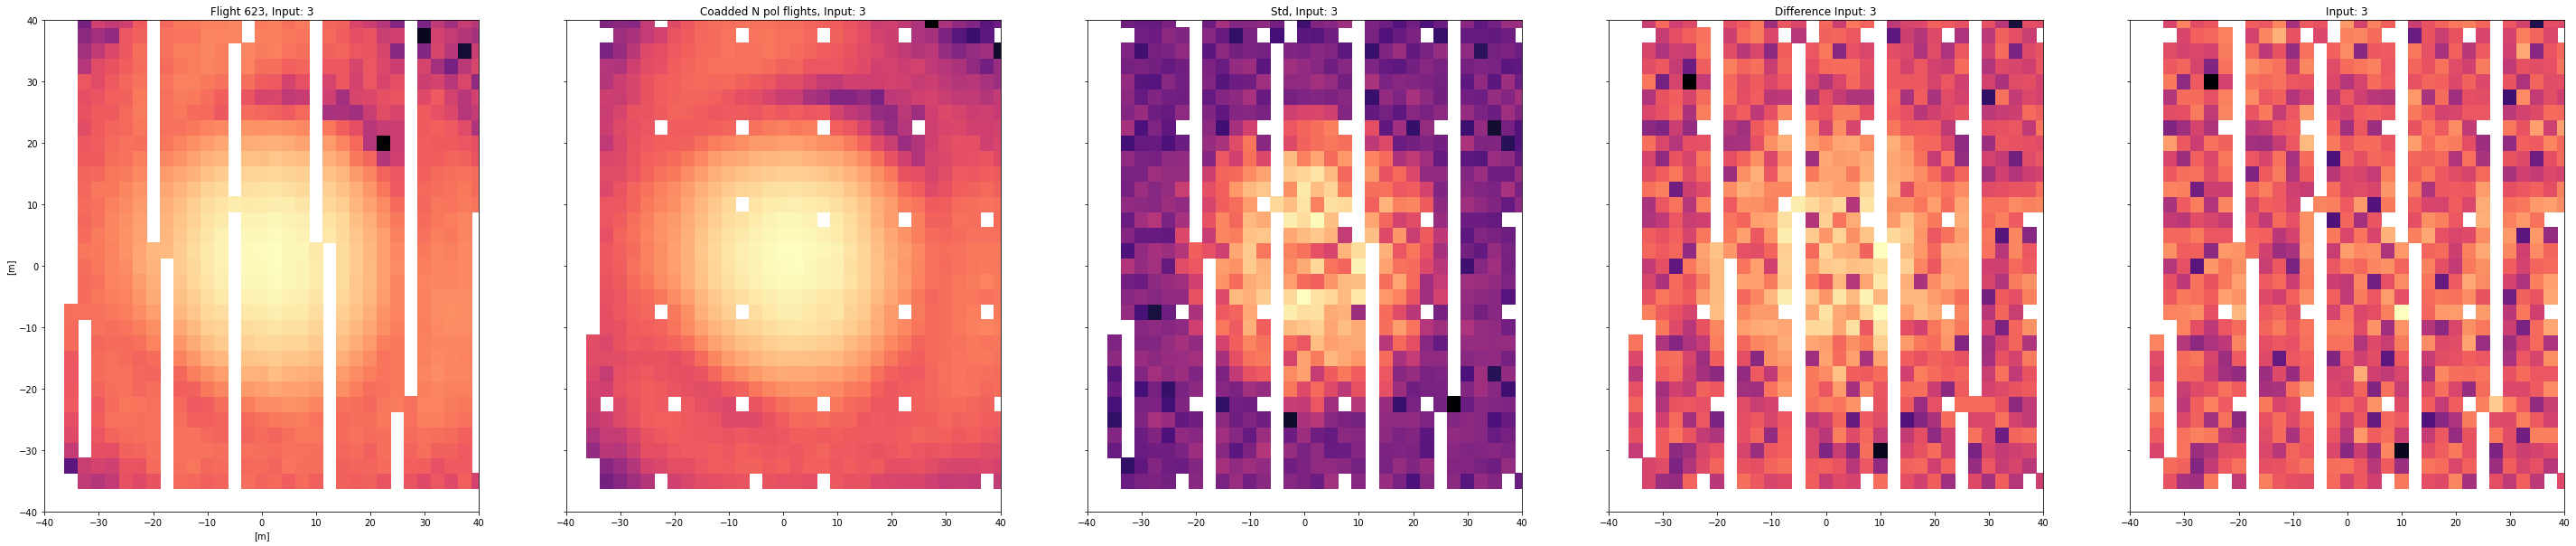

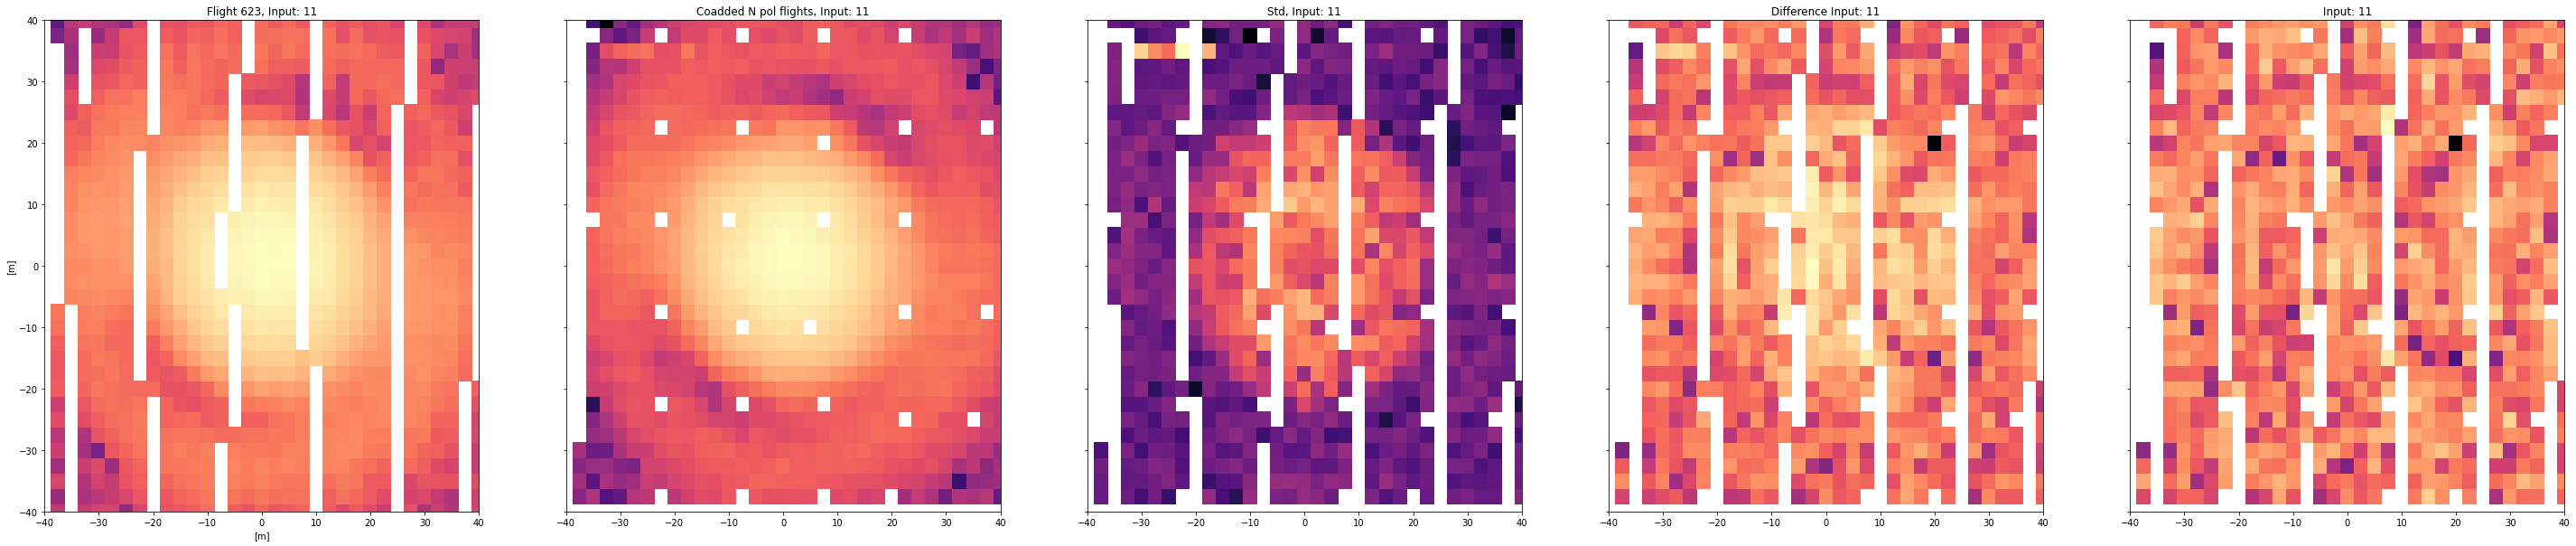

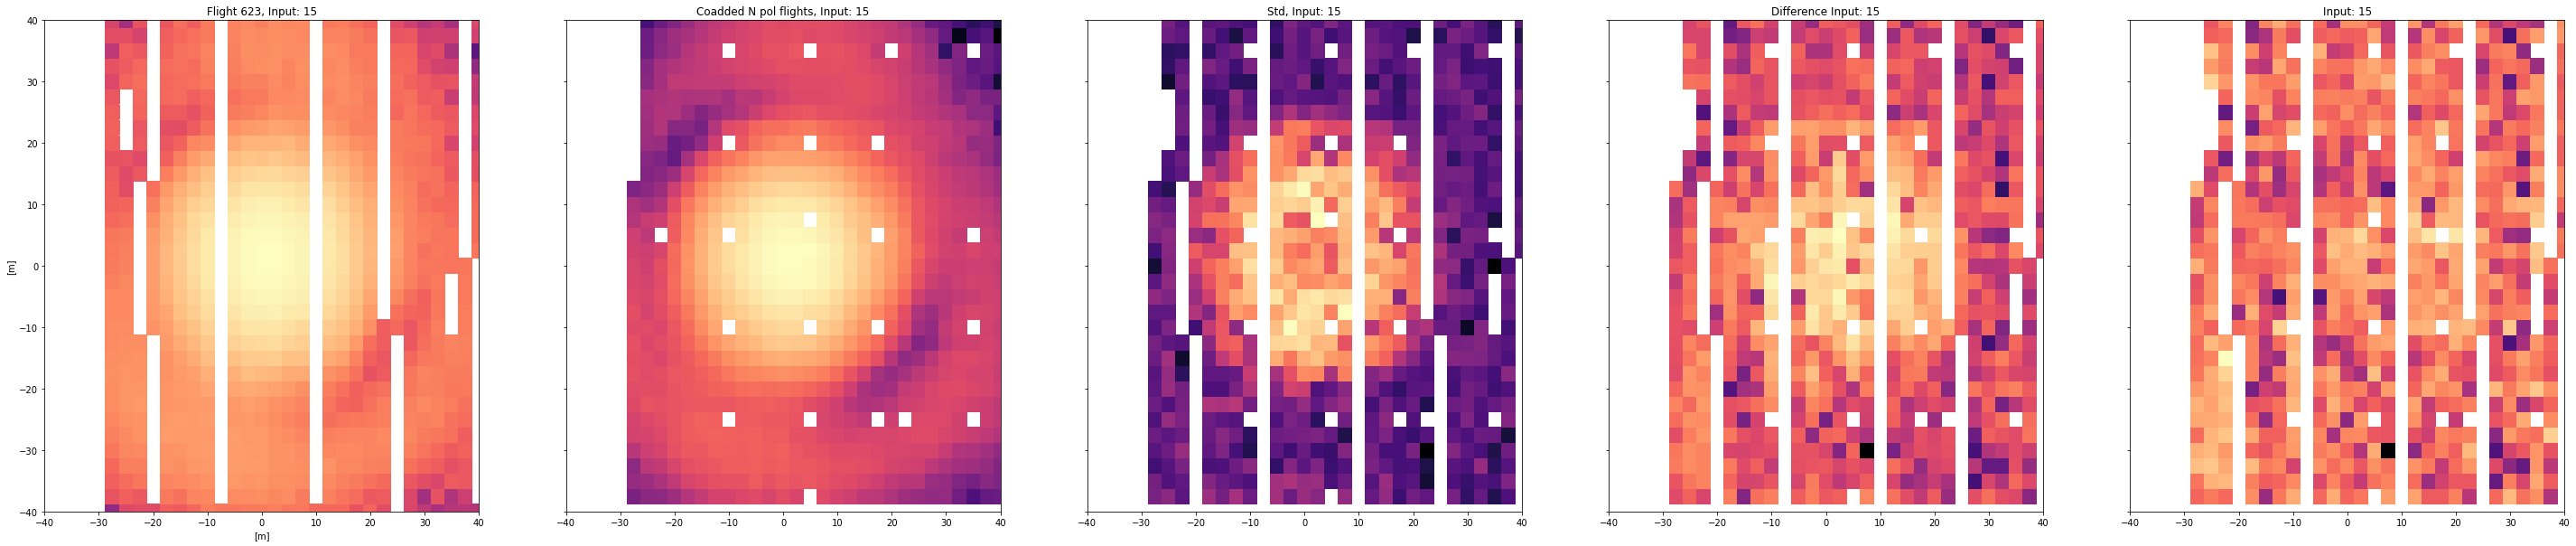

In [76]:
# Plot the two flights, the variance, the difference, and the difference/variance (not std)
for i, chind in enumerate(pols):

    # plot flight 623
    fig,axs = plt.subplots(1, 5, sharex=True,sharey=True,figsize=(50,10))

    axs[0].pcolormesh(fl623_grided.d0_centers_grid[:,:,chind],fl623_grided.d1_centers_grid[:,:,chind],
               np.abs(fl623[:,:,chind]),cmap=cm.magma,norm=LogNorm())#,edgecolors='k')
    axs[0].set_xlim(-40,40)
    axs[0].set_ylim(-40,40)
    axs[0].set_xlabel('[m]')
    axs[0].set_ylabel('[m]')
    axs[0].set_title('Flight 623, Input: '+str(chind))
    #plt.colorbar()

    # plot the co-added flight
    axs[1].pcolormesh(beam.d0_centers_grid[:,:,chind],beam.d1_centers_grid[:,:,chind],
               np.abs(beam.V_LC_operation[:,:,0,chind]),cmap=cm.magma,norm=LogNorm())#,edgecolors='k')
    axs[1].set_title('Coadded N pol flights, Input: '+str(chind))
    #axs[1].colorbar()

    # plot the std
    axs[2].pcolormesh(beam.d0_centers_grid[:,:,chind],beam.d1_centers_grid[:,:,chind],
               np.sqrt(vararr[:,:,chind]),cmap=cm.magma,norm=LogNorm())#,edgecolors='k')
    axs[2].set_title('Std, Input: '+str(chind))
    #plt.colorbar()

    
    # plot the difference

    axs[3].pcolormesh(beam.d0_centers_grid[:,:,chind],beam.d1_centers_grid[:,:,chind],
               abs(diffarr[:,:,chind]),cmap=cm.magma,norm=LogNorm())#,edgecolors='k')
    axs[3].set_title('Difference Input: '+str(chind))
    #plt.colorbar()

    # plot the difference over the std
    axs[4].pcolormesh(beam.d0_centers_grid[:,:,chind],beam.d1_centers_grid[:,:,chind],
               abs(diffarr[:,:,chind]/np.sqrt(vararr[:,:,chind])),
               cmap=cm.magma,norm=LogNorm())#,edgecolors='k')
    axs[4].set_title('Input: '+str(chind))
    #plt.colorbar()
    plt.show()


<ipython-input-77-3dc5114174ee>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axs[0].pcolormesh(fl623_grided.d0_centers_grid[:,:,chind],fl623_grided.d1_centers_grid[:,:,chind],
<ipython-input-77-3dc5114174ee>:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axs[1].pcolormesh(beam.d0_centers_grid[:,:,chind],beam.d1_centers_grid[:,:,chind],
<ipython-input-77-3dc5114174ee>:23: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimension

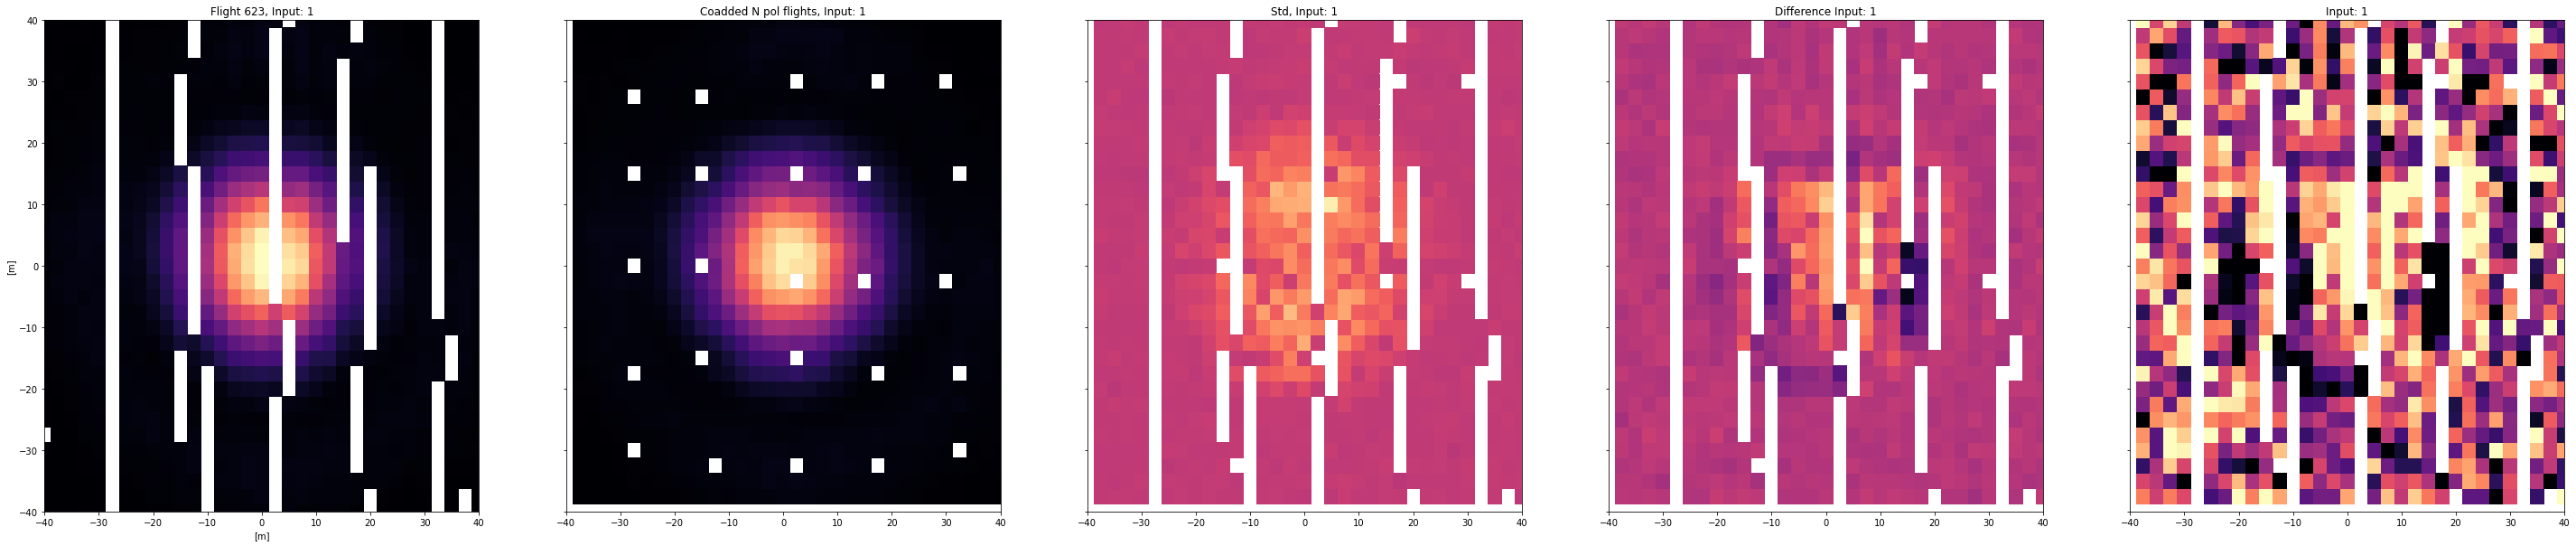

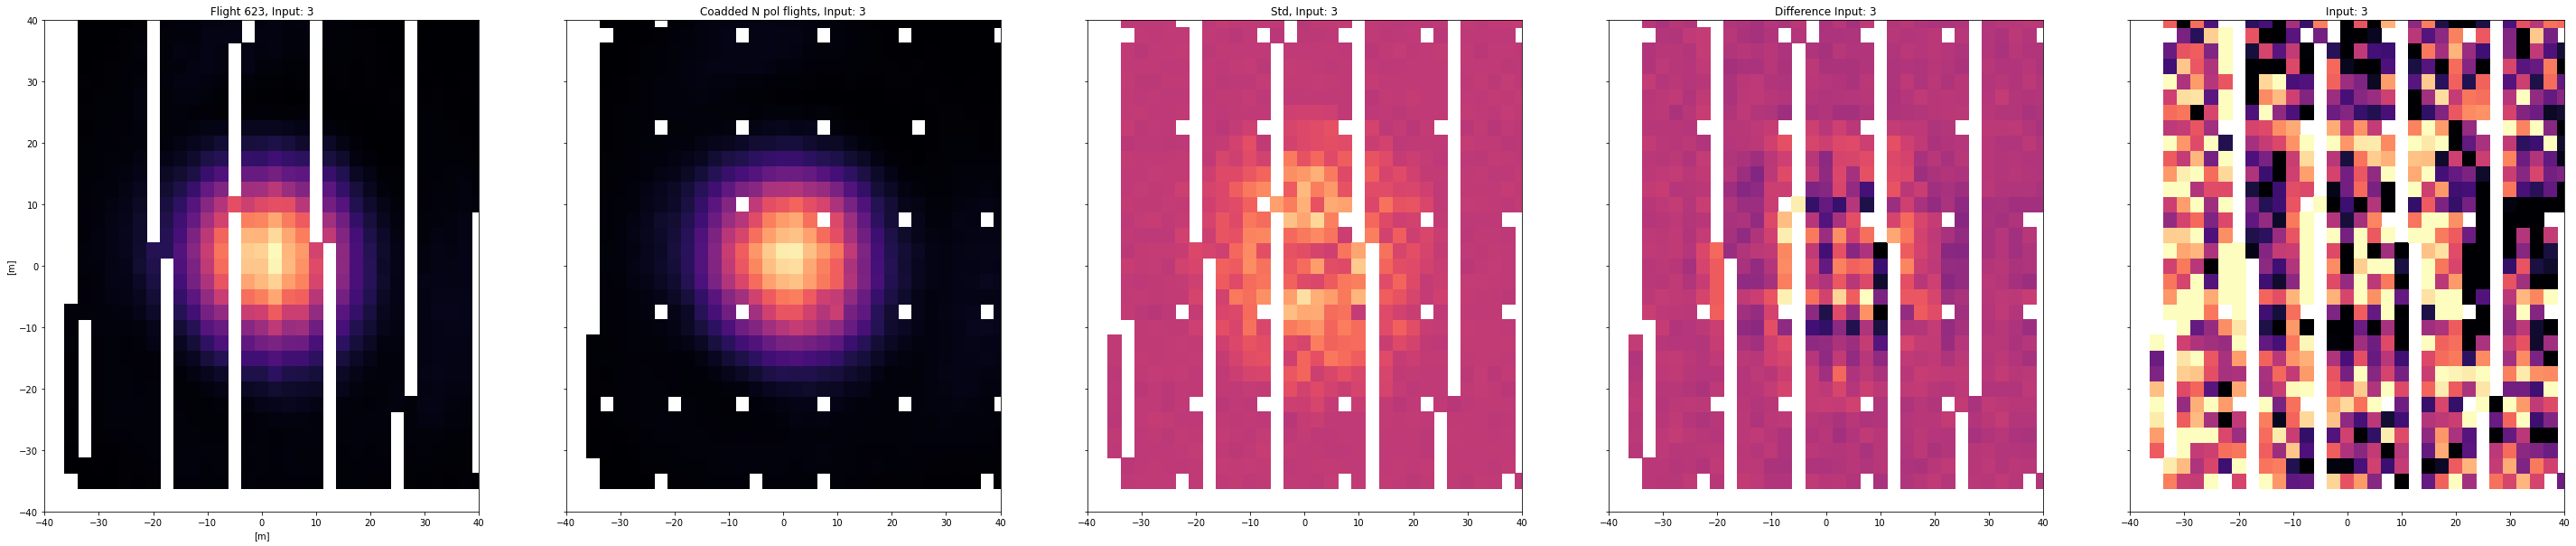

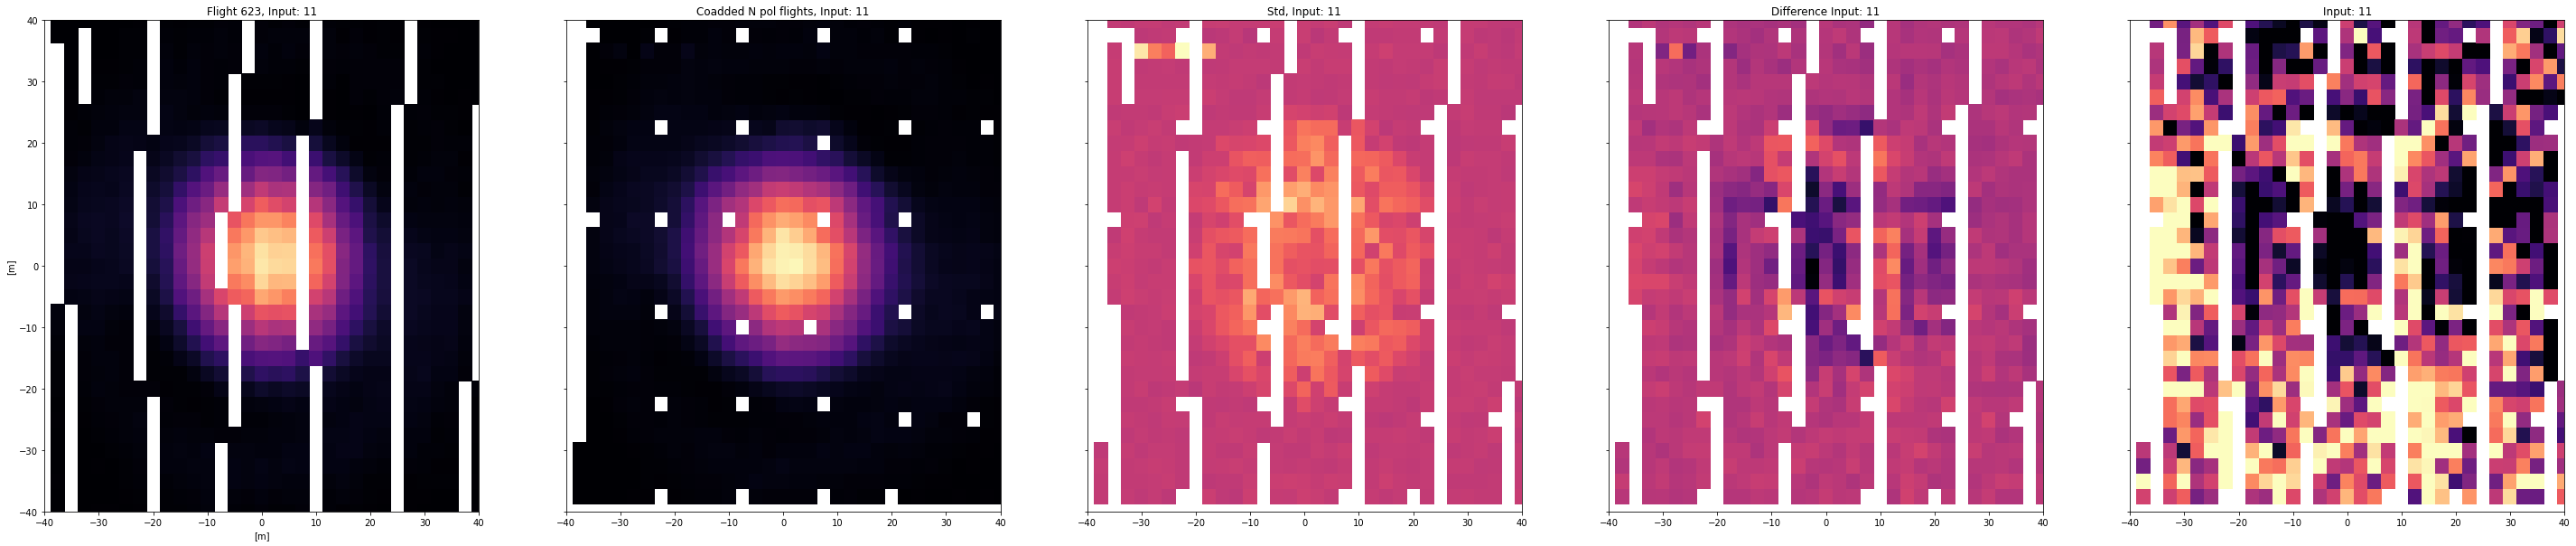

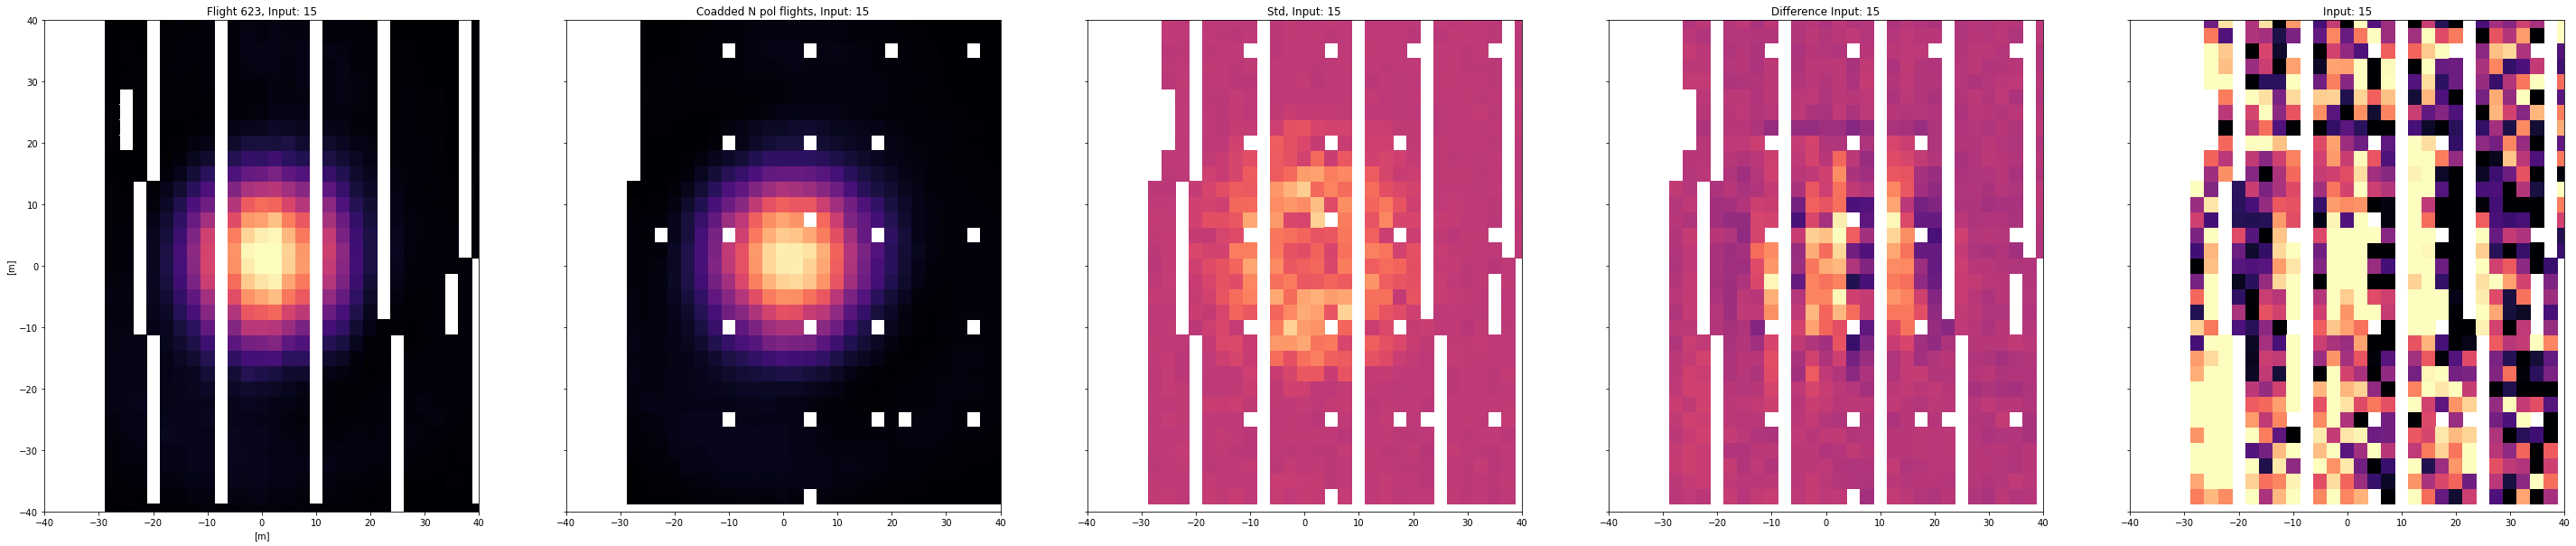

In [77]:
# same as above, in linear space
for i, chind in enumerate(pols):

    # plot flight 623
    fig,axs = plt.subplots(1, 5, sharex=True,sharey=True,figsize=(50,10))

    axs[0].pcolormesh(fl623_grided.d0_centers_grid[:,:,chind],fl623_grided.d1_centers_grid[:,:,chind],
               fl623[:,:,chind],cmap=cm.magma,vmin=1E-4,vmax=1.0)#,edgecolors='k')
    axs[0].set_xlim(-40,40)
    axs[0].set_ylim(-40,40)
    axs[0].set_xlabel('[m]')
    axs[0].set_ylabel('[m]')
    axs[0].set_title('Flight 623, Input: '+str(chind))
    #plt.colorbar()

    # plot the co-added flight
    axs[1].pcolormesh(beam.d0_centers_grid[:,:,chind],beam.d1_centers_grid[:,:,chind],
               beam.V_LC_operation[:,:,0,chind],cmap=cm.magma,vmin=1E-4,vmax=1.0)#,edgecolors='k')
    axs[1].set_title('Coadded N pol flights, Input: '+str(chind))
    #axs[1].colorbar()

    # plot the std
    axs[2].pcolormesh(beam.d0_centers_grid[:,:,chind],beam.d1_centers_grid[:,:,chind],
               np.sqrt(vararr[:,:,chind]),cmap=cm.magma,vmin=-0.1,vmax=0.1)#,edgecolors='k')
    axs[2].set_title('Std, Input: '+str(chind))
    #plt.colorbar()

    
    # plot the difference

    axs[3].pcolormesh(beam.d0_centers_grid[:,:,chind],beam.d1_centers_grid[:,:,chind],
               diffarr[:,:,chind],cmap=cm.magma,vmin=-0.1,vmax=0.1)#,edgecolors='k')
    axs[3].set_title('Difference Input: '+str(chind))
    #plt.colorbar()

    # plot the difference over the std
    axs[4].pcolormesh(beam.d0_centers_grid[:,:,chind],beam.d1_centers_grid[:,:,chind],
               diffarr[:,:,chind]/np.sqrt(vararr[:,:,chind]),
               cmap=cm.magma,vmax=1,vmin=-1)#,edgecolors='k')
    axs[4].set_title('Input: '+str(chind))
    #plt.colorbar()
    plt.show()


In [78]:
#s_diff = np.nanmean(diffarr[:,:,pols],axis=-1)
#s_diff_oe = np.nanmean(diffovererr,axis=-1)
#v_diff = np.nansum(vararr[:,:,pols],axis=-1) 

weights = 1./vararr
diff_weighted = np.nansum(diffarr*weights,axis=-1)/np.nansum(weights,axis=-1)
err_weighted = np.sqrt(1./np.nansum(weights,axis=-1))

n = 32
m = 32

print(beam.V_LC_operation.shape)
print(fl623[n,m,pols])
print(beam.V_LC_operation[n,m,0,pols])
print(diffarr[n,m,pols])
print(vararr[n,m,pols])
print(weights[n,m,pols])
print(diff_weighted[n,m])
print(err_weighted[n,m])

(64, 64, 1, 16)
[       nan 0.99177613 0.90455376 1.04714968]
[0.9713169  0.96722271 0.96410526 0.96371884]
[        nan  0.02455342 -0.0595515   0.08343083]
[       nan 0.00023023 0.00065747 0.00116805]
[          nan 4343.456948   1520.97804414  856.12419036]
0.013019356098809713
0.01219824340423957


<ipython-input-78-5f7cb9368f37>:6: RuntimeWarning: invalid value encountered in true_divide
  diff_weighted = np.nansum(diffarr*weights,axis=-1)/np.nansum(weights,axis=-1)
<ipython-input-78-5f7cb9368f37>:7: RuntimeWarning: divide by zero encountered in true_divide
  err_weighted = np.sqrt(1./np.nansum(weights,axis=-1))


<ipython-input-79-080ed053ca41>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(beam.d0_centers_grid[:,:,chind],beam.d1_centers_grid[:,:,chind],


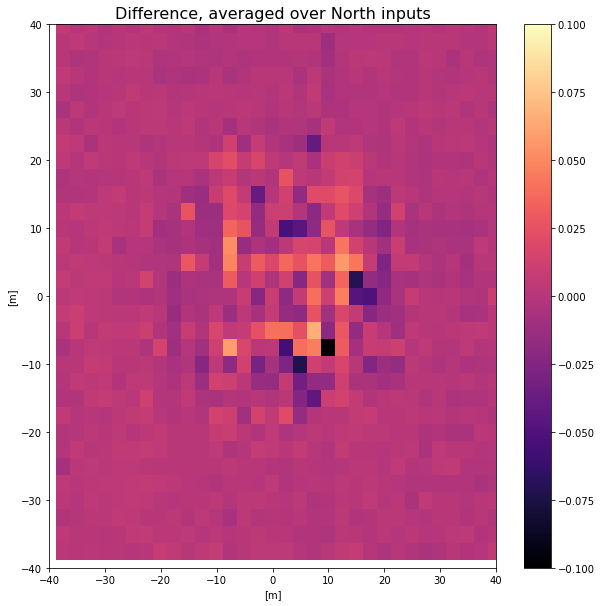

<ipython-input-79-080ed053ca41>:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(beam.d0_centers_grid[:,:,chind],beam.d1_centers_grid[:,:,chind],


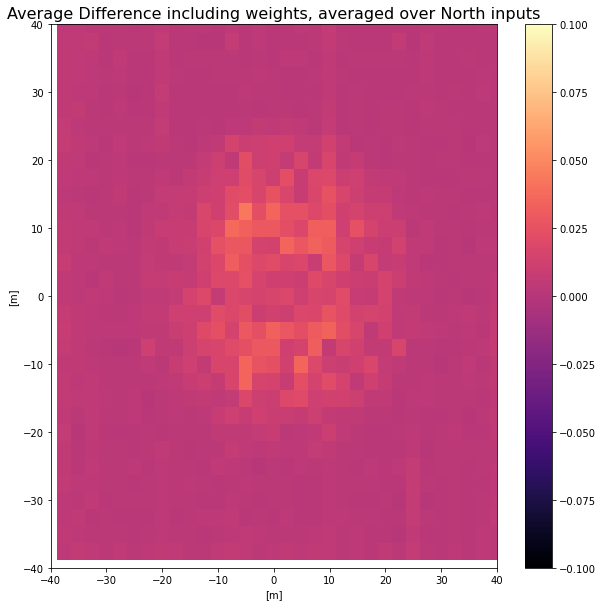

In [79]:
# If we are looking for drone systematics, which should be common to all dishes,
# lets average the differences, and
# average the differences over the variances, to see if we 'integrate' a systematic back out

fig = plt.figure(figsize=(10,10))
plt.pcolormesh(beam.d0_centers_grid[:,:,chind],beam.d1_centers_grid[:,:,chind],
               diff_weighted,cmap=cm.magma,vmin=-0.1,vmax=0.1)#,edgecolors='k')
plt.xlim(-40,40)
plt.ylim(-40,40)
plt.xlabel('[m]')
plt.ylabel('[m]')
plt.title('Difference, averaged over North inputs',fontsize=16)
plt.colorbar()
plt.show()
    
fig = plt.figure(figsize=(10,10))
plt.pcolormesh(beam.d0_centers_grid[:,:,chind],beam.d1_centers_grid[:,:,chind],
               err_weighted, cmap=cm.magma,vmin=-0.1,vmax=0.1)#,edgecolors='k')
plt.xlim(-40,40)
plt.ylim(-40,40)
plt.xlabel('[m]')
plt.ylabel('[m]')
plt.title('Average Difference including weights, averaged over North inputs',fontsize=16)
plt.colorbar()
plt.show()



<ipython-input-131-c9843dd76662>:31: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt0 = axs0.pcolormesh(beam.d0_centers_grid[:,:,chind],beam.d1_centers_grid[:,:,chind],
<ipython-input-131-c9843dd76662>:44: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt0 = axs1.pcolormesh(beam.d0_centers_grid[:,:,chind],beam.d1_centers_grid[:,:,chind],


Text(0.5, 0, 'Distance [m]')

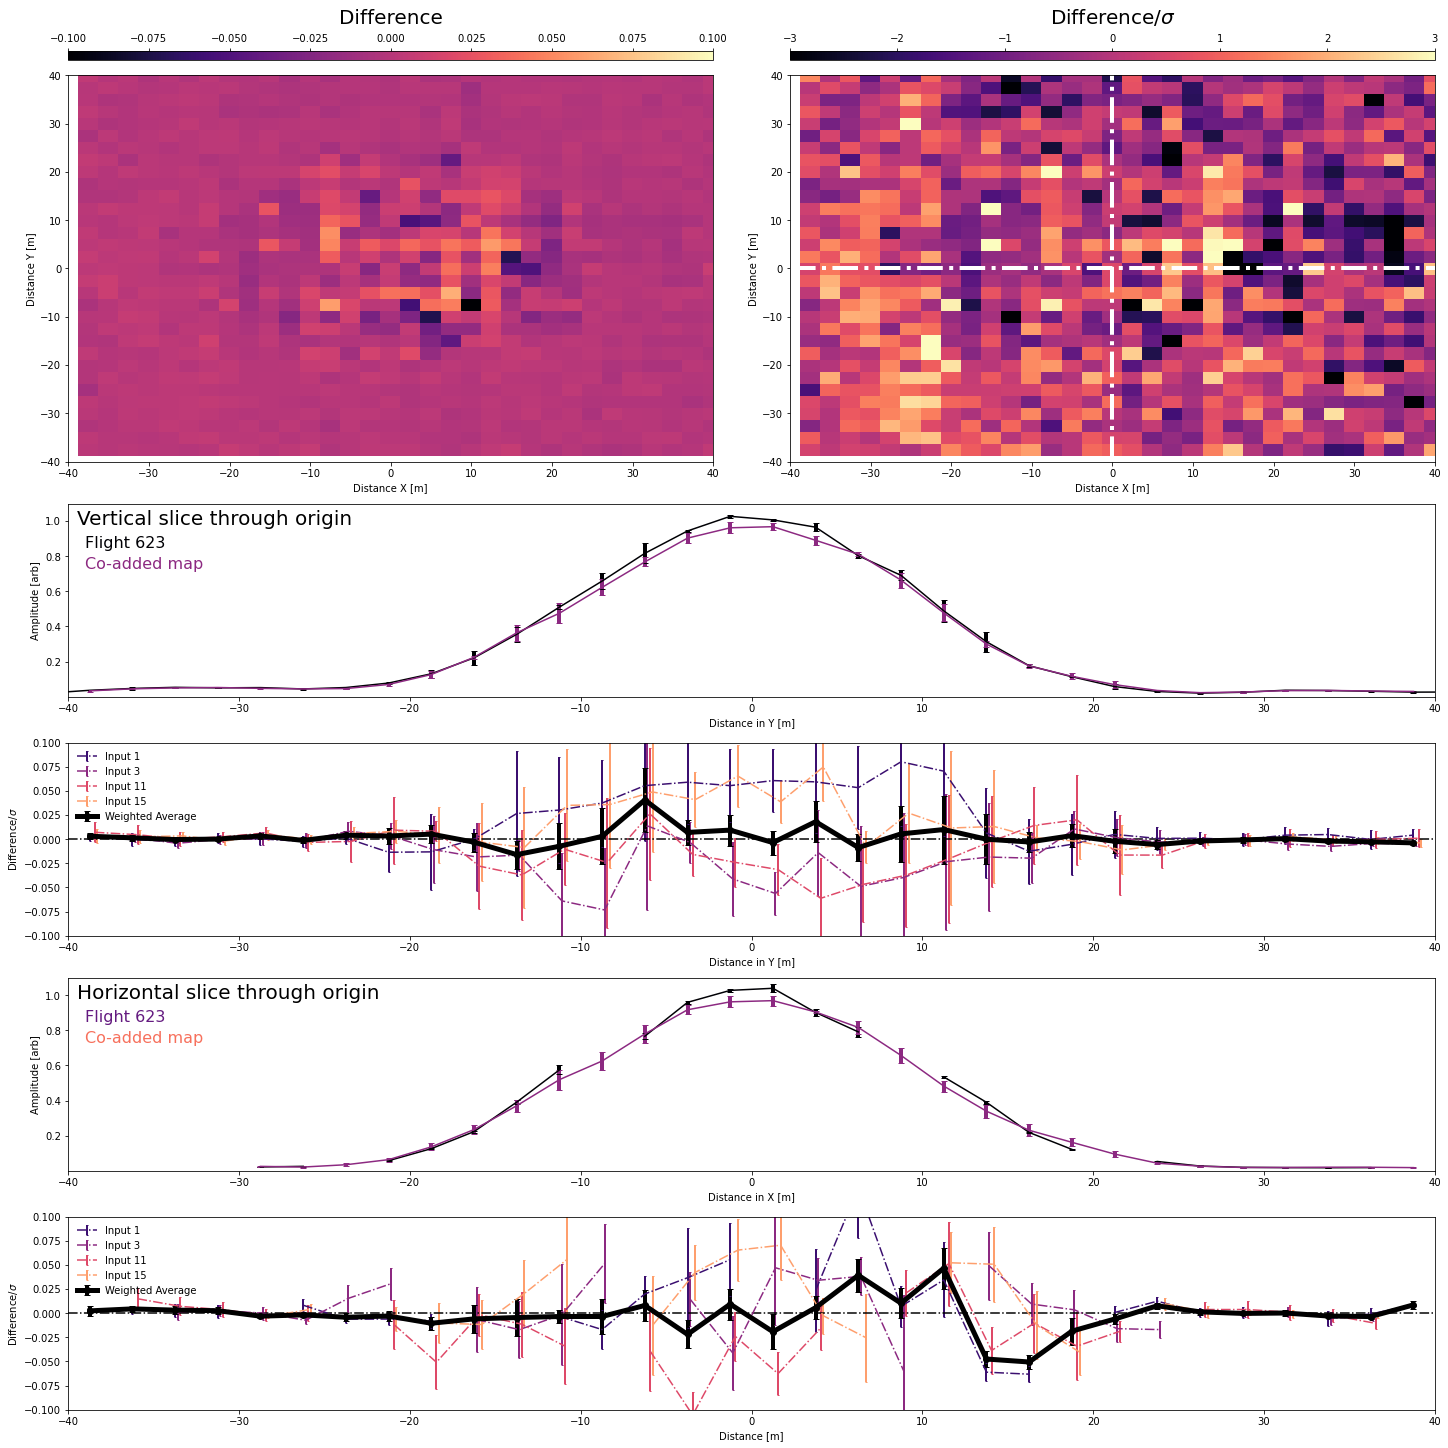

In [131]:


colors=pu.cm_to_discrete(cm.magma, 10)
xx = 0
c = 0

# This is the channel that gets plotted
ci=3
chi = pols[ci]

colx = pu.get_slice(fl623_grided.d0_centers_grid[:,:,0],
                    fl623_grided.d1_centers_grid[:,:,0],
                    fl623[:,:,chind],xx, sliceOrientation='v')
coly = pu.get_slice(fl623_grided.d0_centers_grid[:,:,0],
                    fl623_grided.d1_centers_grid[:,:,0],
                    fl623[:,:,chind],xx, sliceOrientation='h')


from matplotlib.gridspec import GridSpec

fig = plt.figure(constrained_layout=True,figsize=(20,20))

gs = GridSpec(6, 2, height_ratios=[0.05,2,1,1,1,1], width_ratios=[0.5,0.5],figure=fig)

axs0 = fig.add_subplot(gs[1, 0])
axs1 = fig.add_subplot(gs[1, 1])
axs2 = fig.add_subplot(gs[2, :])
axs3 = fig.add_subplot(gs[3, :])
axs4 = fig.add_subplot(gs[4, :])
axs5 = fig.add_subplot(gs[5, :])

# Diff plot and colorbar
plt0 = axs0.pcolormesh(beam.d0_centers_grid[:,:,chind],beam.d1_centers_grid[:,:,chind],
               diff_weighted,cmap=cm.magma,vmin=-0.1,vmax=0.1)#,edgecolors='k')
axs0.set_xlim(-40,40)
axs0.set_ylim(-40,40)
axs0.set_xlabel('Distance X [m]')
axs0.set_ylabel('Distance Y [m]')
#axs0.text(-35,35,'Difference, averaged over inputs',color='white',fontsize=20,weight='bold')
cbax = plt.subplot(gs[0, 0])
cb = Colorbar(ax = cbax, mappable = plt0, orientation = 'horizontal', ticklocation = 'top')
cb.set_label('Difference', labelpad=10,fontsize=20)


# Diff/sigma plot and colorbar
plt0 = axs1.pcolormesh(beam.d0_centers_grid[:,:,chind],beam.d1_centers_grid[:,:,chind],
               diff_weighted/err_weighted, cmap=cm.magma,vmax=3,vmin=-3)#,edgecolors='k')
axs1.axhline(0,color='white',linestyle='-.',linewidth=4)
axs1.axvline(0,color='white',linestyle='-.',linewidth=4)
axs1.set_xlim(-40,40)
axs1.set_ylim(-40,40)
axs1.set_xlabel('Distance X [m]')
axs1.set_ylabel('Distance Y [m]')
#axs1.text(-30,30,'Difference/Std, averaged over inputs',color='white',weight='bold',fontsize=20)
cbax = plt.subplot(gs[0, 1])
cb = Colorbar(ax = cbax, mappable = plt0, orientation = 'horizontal', ticklocation = 'top')
cb.set_label(r'Difference/$\sigma$', labelpad=10,fontsize=20)

# Vertical Slice for two flights, one channel
axs2.errorbar(beam.d1_centers_grid[colx,:,0],fl623[colx,:,chi],
                yerr=fl623_err[colx,:,chi],elinewidth=4,capsize=3,
             color=colors[c],label='Flight 623')

axs2.errorbar(fl623_grided.d1_centers_grid[colx,:,0],beam.V_LC_operation[colx,:,0,chi],
                yerr=beam.V_LC_operation_err[colx,:,0,chi],elinewidth=4,capsize=3,
             color=colors[c+4],label='Co-added flights')
axs2.text(-39.5,0.98,'Vertical slice through origin',color='black',fontsize=20)
axs2.text(-39,0.85,'Flight 623',color=colors[c],fontsize=16)
axs2.text(-39,0.73,'Co-added map',color=colors[c+4],fontsize=16)
axs2.set_ylim(1E-4,1.1)
axs2.set_xlim(-40,40)
axs2.set_ylabel('Amplitude [arb]')
axs2.set_xlabel('Distance in Y [m]')

# Vertical Slice for all channels, and average
for c,chind in enumerate(pols):
    axs3.errorbar(fl623_grided.d1_centers_grid[colx,:,0]+(c*0.15),diffarr[colx,:,chind],
             yerr=np.sqrt(vararr[colx,:,chind]),elinewidth=2,capsize=1,linestyle='-.',
                  color=colors[2*c + 2],label='Input '+str(chind))
    
axs3.errorbar(fl623_grided.d1_centers_grid[colx,:,0],diff_weighted[colx,:],
             yerr=err_weighted[colx,:],
              marker='o',color='black',linewidth=5,elinewidth=4,capsize=3,
              label='Weighted Average')
axs3.axhline(0,linestyle='-.',color='black')
axs3.set_ylim(-0.1,0.1)
axs3.set_xlim(-40,40)
axs3.legend(loc='upper left',frameon=False)
axs3.set_ylabel(r'Difference/$\sigma$')
axs3.set_xlabel('Distance in Y [m]')

# Horizontal slice for two flights, one channel
axs4.errorbar(fl623_grided.d0_centers_grid[:,coly,0],fl623[:,coly,chi],
                yerr=fl623_err[:,coly,chi],elinewidth=4,capsize=3,
            color=colors[0],label='Flight 623')
axs4.errorbar(fl623_grided.d0_centers_grid[:,coly,0],beam.V_LC_operation[:,coly,0,chi],
                yerr=beam.V_LC_operation_err[:,coly,0,chi],elinewidth=4,capsize=3,
             color=colors[4],label='Co-added flights')
axs4.set_ylim(1E-4,1.1)
axs4.set_xlim(-40,40)
axs4.text(-39.5,0.98,'Horizontal slice through origin',color='black',fontsize=20)
axs4.text(-39,0.85,'Flight 623',color=colors[c],fontsize=16)
axs4.text(-39,0.73,'Co-added map',color=colors[c+4],fontsize=16)
axs4.set_xlabel('Distance in X [m]')
axs4.set_ylabel('Amplitude [arb]')

for c,chind in enumerate(pols):
    axs5.errorbar(fl623_grided.d0_centers_grid[:,coly,0]+(c*0.15),diffarr[:,coly,chind],
                  yerr=np.sqrt(vararr[:,coly,chind]),elinewidth=2,capsize=1,linestyle='-.',
                  color=colors[2*c + 2],label='Input '+str(chind))
axs5.errorbar(fl623_grided.d0_centers_grid[:,coly,0],diff_weighted[:,coly],
             yerr=err_weighted[:,coly],marker='o',color='black',linewidth=5,elinewidth=4,capsize=3,
              label='Weighted Average')
axs5.axhline(0,linestyle='-.',color='black')
axs5.set_ylim(-0.1,0.1)
axs5.set_xlim(-40,40)
axs5.legend(loc='upper left',frameon=False)
axs5.set_ylabel(r'Difference/$\sigma$')
axs5.set_xlabel('Distance [m]')



In [81]:
print garble just to make this fail

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(garble just to make this fail)? (<ipython-input-81-f1714dedf6b5>, line 1)

In [ ]:
## POLAR VERSION  ###

In [ ]:
# Lets look at only the N-pol flights at the same attenuation, pick one frequency

Npolflights = ['618','619','625']
Npolflights = ['618','619']

pflights=Npolflights
find=900

concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for fly in pflights]
delt_the = np.radians(6)
delt_phi = np.radians(1)

beam=ba.Beammap_polar(concatlist=concytest,coordsys='polar',
                 normalization='Gauss_wcorr',operation='std',mask=False,
                                  d0args=[-delt_the/2.0,(60*delt_the)-(delt_the/2.0),delt_the],
                 d1args=[0,np.radians(36),delt_phi],Fargs=[find,find+1,1],f_index=find)

pols = N_pols

fig, axs = plt.subplots(4,1, subplot_kw=dict(projection="polar"),figsize=(10,10))

for i,chind in enumerate(pols):
    axs[i].pcolormesh(beam.d0_centers_grid[:,:,chind],beam.d1_centers_grid[:,:,chind],
               np.abs(beam.V_LC_operation[:,:,0,chind]),cmap=cm.magma,norm=LogNorm())#,edgecolors='k')
    axs[i].set_title('Input: '+str(chind))
    axs[i].set_ylim(0,0.35)
    #plt.colorbar()
plt.show()

fig, axs = plt.subplots(4,1, subplot_kw=dict(projection="polar"),figsize=(16,8))
for i,chind in enumerate(pols):
    #fig = plt.figure(figsize=(10,10),projection="polar")
    axs[i].pcolormesh(beam.d0_centers_grid[:,:,chind],beam.d1_centers_grid[:,:,chind],
               beam.V_LC_operation_err[:,:,0,chind],cmap=cm.inferno)#,edgecolors='k')
    axs[i].set_title('Input: '+str(chind))
    axs[i].set_ylim(0,0.35)
    #axs[i].colorbar()
plt.show()

In [ ]:
fly='623'

pol, pols, cpols, attn, fi = get_flightinfo(fly)
print(fly,pol,pols,cpols, attn)

# have to use Will's function, can't mask
fl623_grided=bp.Beammap(concatlist=pcklarr[[fi]],gfitlist=gfitarr[[fi]],coordsys='polar',
                 normalization='Gauss',operation='coadd',
                                  d0args=[-delt_the/2.0,(60*delt_the)-(delt_the/2.0),delt_the],
                 d1args=[0,np.radians(36),delt_phi],Fargs=[find,find+1,1],f_index_cc=find,vplot=False)


pklfile = ampdir+'FLY'+str(fly)+'_Corrected_amplitudes.pkl'
with open(pklfile, 'rb') as inp:
    amps = pickle.load(inp)
    
fl623 = fl623_grided.V_LC_mean[:,:,0,:,0]*amps[0,find,:]

pols = N_pols

fig, axs = plt.subplots(4,1, subplot_kw=dict(projection="polar"),figsize=(10,10))

for i,chind in enumerate(pols):
    im=axs[i].pcolormesh(fl623_grided.d0_centers_grid[:,:,chind],fl623_grided.d1_centers_grid[:,:,chind],
               np.abs(fl623_grided.V_LC_mean[:,:,0,chind,0]*amps[0,find,chind]),cmap=cm.magma,norm=LogNorm())#,edgecolors='k')
    axs[i].set_title('Input: '+str(chind))
    axs[i].set_ylim(0,0.35)
cbar=fig.colorbar(im,ax=axs,aspect=50)
cbar.set_label('Amplitude [dB]')
plt.show()

fig, axs = plt.subplots(4,1, subplot_kw=dict(projection="polar"),figsize=(16,8))
for i,chind in enumerate(pols):
    #fig = plt.figure(figsize=(10,10),projection="polar")
    axs[i].pcolormesh(fl623_grided.d0_centers_grid[:,:,chind],fl623_grided.d1_centers_grid[:,:,chind],
               fl623_grided.V_LC_std[:,:,0,chind,0]*amps[0,find,chind],cmap=cm.inferno)#,edgecolors='k')
    axs[i].set_title('Input: '+str(chind))
    axs[i].set_ylim(0,0.35)
    #axs[i].colorbar()
plt.show()

In [ ]:
# Ltat looks pretty good, lets plot the differences for all the channels
# and the differences over the variance

fig, axs = plt.subplots(4,1, subplot_kw=dict(projection="polar"),figsize=(10,10))
for i,chind in enumerate(pols):
    axs[i].pcolormesh(beam.d0_centers_grid[:,:,chind],beam.d1_centers_grid[:,:,chind],
               (fl623_grided.V_LC_mean[:,:,0,chind,0]*amps[0,find,chind] - beam.V_LC_operation[:,:,0,chind]),
               cmap=cm.magma,vmin=-0.1,vmax=0.1)#,edgecolors='k')
    axs[i].set_ylim(0,0.35)
    #axs[i].set_title('Input: '+str(chind))
plt.show()

fig, axs = plt.subplots(4,1, subplot_kw=dict(projection="polar"),figsize=(10,10))
    
for i,chind in enumerate(pols):
    axs[i].pcolormesh(beam.d0_centers_grid[:,:,chind],beam.d1_centers_grid[:,:,chind],
               (fl623_grided.V_LC_mean[:,:,0,chind,0]*amps[0,find,chind] - beam.V_LC_operation[:,:,0,chind])/beam.V_LC_operation_err[:,:,0,chind],
               cmap=cm.magma,vmax=2.0,vmin=-10.0)#,edgecolors='k')
    #axs[i].set_ylim(0,0.15)
    #axs[i].set_title('Input: '+str(chind))
plt.show()

In [ ]:
diff = fl623_grided.V_LC_mean[:,:,0,pols,0]*amps[0,find,pols] - beam.V_LC_operation[:,:,0,pols]
errs = np.sqrt(beam.V_LC_operation_err[:,:,0,pols]**2 + 
               fl623_grided.V_LC_std[:,:,0,pols,0]*amps[0,find,pols]**2)
diffovererr = diff/errs

s_diff = np.nanmean(diff,axis=-1)
s_diff_oe = np.nanmean(diffovererr,axis=-1)

fig, axs = plt.subplots(1,2, subplot_kw=dict(projection="polar"),figsize=(20,20))

im = axs[0].pcolormesh(beam.d0_centers_grid[:,:,chind],beam.d1_centers_grid[:,:,chind],
               s_diff,cmap=cm.magma,vmin=-0.05,vmax=0.05)#,edgecolors='k')
axs[0].set_ylim(0,0.15)
axs[0].set_title('Difference (power)')
cbar=fig.colorbar(im,ax=axs,aspect=10)
    
im = axs[1].pcolormesh(beam.d0_centers_grid[:,:,chind],beam.d1_centers_grid[:,:,chind],
               s_diff_oe, cmap=cm.magma,vmax=2.0,vmin=-2.0)#,edgecolors='k')
axs[1].set_ylim(0,0.15)
axs[1].set_title('Difference/ errors')
cbar=fig.colorbar(im,ax=axs,aspect=10)

plt.show()